# Load dataset

In [1]:
import pandas as pd

# load dataset
df = pd.read_csv('2022_04_22_hour_heartbeat_merged.csv')

# Convert 'time' column to datetime format
df['Time'] = pd.to_datetime(df['time'])
df.describe()

,Beats,Id,Intensity,Steps
count,6252.000000,6.252000e+03,6246.000000,6246.000000
mean,73.845170,5.638328e+09,16.101185,431.416747
std,14.799422,1.864900e+09,25.190960,811.960176
min,46.000000,2.022484e+09,0.000000,0.000000
25%,63.000000,4.558610e+09,0.000000,0.000000
50%,71.000000,5.577150e+09,7.000000,130.000000
75%,81.000000,6.962181e+09,22.000000,542.000000
max,167.000000,8.877689e+09,180.000000,10554.000000


# Clean Dataset

In [2]:
# Fill the missing values with zeros for the specific patient 5553957443 in the full dataset
df.loc[df['Id'] == 5553957443, ['Intensity', 'Steps']] = df.loc[df['Id'] == 5553957443, ['Intensity', 'Steps']].fillna(0)

# Verify by checking for any remaining missing values for patient 5553957443
remaining_missing_values_patient = df[df['Id'] == 5553957443].isnull().sum()

remaining_missing_values_patient

time         0
Beats        0
Id           0
Intensity    0
Steps        0
Time         0
dtype: int64

In [3]:
# Checking for missing values in the dataset
missing_values_by_patient = df[df.isnull().any(axis=1)]

# Applying the previous valid observation to fill the remaining missing values for each patient with missing data
for patient_id, patient_data in missing_values_by_patient.groupby('Id'):
    
    patient_df = df[df['Id'] == patient_id]
    missing_indices = patient_data.index
    # Apply the previous valid observation forward to fill the missing values
    df.loc[patient_df.index, ['Intensity', 'Steps']] = patient_df[['Intensity', 'Steps']].fillna(method='ffill')

# Check if all missing values are gone
all_missing_values_filled = df.isna().sum()
all_missing_values_filled

time         0
Beats        0
Id           0
Intensity    0
Steps        0
Time         0
dtype: int64

# Split dataset into train, val, test and scale it

In [4]:
from sklearn . preprocessing import MinMaxScaler


split_index = int(len(df) * 0.7)

# Split the data into training and testing sets
train_data = df.iloc[:split_index]
test_data = df.iloc[split_index:]

# Define the columns we want to scale
columns_to_scale = ['Beats', 'Intensity', 'Steps']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data aand transform it
train_data_scaled = scaler.fit_transform(train_data[columns_to_scale])

# Use the same scaler to transform the testing data
test_data_scaled = scaler.transform(test_data[columns_to_scale])

train_data_scaled_df = pd.DataFrame(train_data_scaled, index=train_data.index, columns=columns_to_scale)
test_data_scaled_df = pd.DataFrame(test_data_scaled, index=test_data.index, columns=columns_to_scale)

train_data_scaled_df['Time'] = train_data['Time']
test_data_scaled_df['Time'] = test_data['Time']

train_data_scaled_df.head(), test_data_scaled_df.head()

(      Beats  Intensity  Steps                Time
 0  0.456790        0.0    0.0 2016-04-12 01:00:00
 1  0.395062        0.0    0.0 2016-04-12 02:00:00
 2  0.246914        0.0    0.0 2016-04-12 03:00:00
 3  0.271605        0.0    0.0 2016-04-12 04:00:00
 4  0.271605        0.0    0.0 2016-04-12 05:00:00,
          Beats  Intensity     Steps                Time
 4376  0.444444   0.255556  0.234160 2016-04-19 09:00:00
 4377  0.555556   0.627778  0.702996 2016-04-19 10:00:00
 4378  0.333333   0.044444  0.016185 2016-04-19 11:00:00
 4379  0.271605   0.011111  0.007748 2016-04-19 12:00:00
 4380  0.283951   0.066667  0.044421 2016-04-19 13:00:00)

# Add and Remove Features

In [5]:
# intensity an hour before
train_data_scaled_df['Intensity_1h_before'] = train_data_scaled_df['Intensity'].shift(1)
test_data_scaled_df['Intensity_1h_before'] = test_data_scaled_df['Intensity'].shift(1)

# time based feature, hour of the day
train_data_scaled_df['Hour_of_day'] = train_data_scaled_df['Time'].dt.hour
test_data_scaled_df['Hour_of_day'] = test_data_scaled_df['Time'].dt.hour

# remove time
train_data_scaled_df = train_data_scaled_df.drop(['Time'], axis=1)
test_data_scaled_df = test_data_scaled_df.drop(['Time'], axis=1)

# LSTM data preperation

In [6]:
import numpy as np
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

np_array = np.array(train_data_scaled_df['Hour_of_day']).reshape(-1, 1)

# Fit the scaler on the training data aand transform it
train_data_scaled = scaler.fit_transform(np_array)

test_np_array = np.array(test_data_scaled_df['Hour_of_day']).reshape(-1, 1)

# Use the same scaler to transform the testing data
test_data_scaled = scaler.transform(test_np_array)

train_data_scaled_df['Hour_of_day'] = train_data_scaled
test_data_scaled_df['Hour_of_day'] = test_data_scaled

train_data_scaled_df.head(), test_data_scaled_df.head()

(      Beats  Intensity  Steps  Intensity_1h_before  Hour_of_day
 0  0.456790        0.0    0.0                  NaN     0.043478
 1  0.395062        0.0    0.0                  0.0     0.086957
 2  0.246914        0.0    0.0                  0.0     0.130435
 3  0.271605        0.0    0.0                  0.0     0.173913
 4  0.271605        0.0    0.0                  0.0     0.217391,
          Beats  Intensity     Steps  Intensity_1h_before  Hour_of_day
 4376  0.444444   0.255556  0.234160                  NaN     0.391304
 4377  0.555556   0.627778  0.702996             0.255556     0.434783
 4378  0.333333   0.044444  0.016185             0.627778     0.478261
 4379  0.271605   0.011111  0.007748             0.044444     0.521739
 4380  0.283951   0.066667  0.044421             0.011111     0.565217)

## Create Sequences

In [7]:
# Define sequence length and prepare the final sequences for training
import numpy as np
train_data_scaled_df.dropna(inplace=True)
train_data_scaled_df.reset_index(drop=True, inplace=True)
sequence_length = 10  # Length of each sequence
y = train_data_scaled_df['Intensity'] 
X = train_data_scaled_df.drop(['Intensity'], axis=1)  # Features
X_seq = []
y_seq = []

for i in range(sequence_length, len(train_data_scaled_df)):
    X_seq.append(X[i-sequence_length:i])
    y_seq.append(y[i])

X_train_seq = np.array(X_seq)
y_train_seq = np.array(y_seq)

# Display shape of the sequences
X_train_seq.shape, y_train_seq.shape

((4365, 10, 4), (4365,))

In [8]:
# Define sequence length and prepare the final sequences for test data
import numpy as np
test_data_scaled_df.dropna(inplace=True)
test_data_scaled_df.reset_index(drop=True, inplace=True)
y = test_data_scaled_df['Intensity'] 
X = test_data_scaled_df.drop(['Intensity'], axis=1)  # Features

sequence_length = 10 # Length of each sequence

X_seq = []
y_seq = []

for i in range(sequence_length, len(test_data_scaled_df)):
    X_seq.append(X[i-sequence_length:i])
    y_seq.append(y[i])

X_test_seq = np.array(X_seq)
y_test_seq = np.array(y_seq)

# Display shape of the sequences
X_test_seq.shape, y_test_seq.shape

((1865, 10, 4), (1865,))

# Build LSTM model

In [9]:
# Define the model
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Fully connected layer
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # out stands for hidden state h in every time step
        # _ stands for cell state c in every time step
        out, _ = self.lstm(x)

        # out[:, -1, :] selects the hidden state of the last time step for each sequence in the batch.
        # self.linear maps the hidden state to the output dimesnion feature
        out = self.linear(out[:, -1, :])
        return out

In [10]:
# model configuration
input_size = X_train_seq.shape[2]  # number of features
hidden_size = 64  # number of features in hidden states
num_layers = 2  # number of stacked LSTM layers
output_size = 1  # number of output features

# Initialize the model
model = LSTM(input_size, hidden_size, num_layers, output_size)

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train LSTM model

In [11]:
from sklearn.model_selection import train_test_split
# Split data into training and evaluation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_seq, y_train_seq, test_size=0.2, shuffle =False)

In [12]:
# Convert to PyTorch tensors
import torch
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)

X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val).view(-1,1)
# Prepare DataLoader for training data
batch_size = 64
train_dataset = TensorDataset(X_train_tensor , y_train_tensor)
train_loader = DataLoader(train_dataset , batch_size=batch_size , shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [13]:
# Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 50
model.to(device)
for epoch in range(num_epochs):
    total_loss = 0.0 # To accumulate loss for each epoch
    model.train()
    for batch_X , batch_y in train_loader:
        # Move data to the appropriate device if necessary (e.g., GPU)
        batch_X , batch_y = batch_X.to(device), batch_y.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch_X.size(0)
        # Calculate average loss for the epoch
    epoch_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training_Loss: {epoch_loss:.4f}")
    
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X , batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item() * batch_X.size(0)
        epoch_loss = total_loss / len(val_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Eval_Loss: {epoch_loss:.4f}")

Epoch [1/50], Training_Loss: 0.0213
Epoch [1/50], Eval_Loss: 0.0097
Epoch [2/50], Training_Loss: 0.0173
Epoch [2/50], Eval_Loss: 0.0081
Epoch [3/50], Training_Loss: 0.0166
Epoch [3/50], Eval_Loss: 0.0078
Epoch [4/50], Training_Loss: 0.0163
Epoch [4/50], Eval_Loss: 0.0082
Epoch [5/50], Training_Loss: 0.0162
Epoch [5/50], Eval_Loss: 0.0079
Epoch [6/50], Training_Loss: 0.0161
Epoch [6/50], Eval_Loss: 0.0084
Epoch [7/50], Training_Loss: 0.0161
Epoch [7/50], Eval_Loss: 0.0076
Epoch [8/50], Training_Loss: 0.0160
Epoch [8/50], Eval_Loss: 0.0086
Epoch [9/50], Training_Loss: 0.0160
Epoch [9/50], Eval_Loss: 0.0077
Epoch [10/50], Training_Loss: 0.0157
Epoch [10/50], Eval_Loss: 0.0074
Epoch [11/50], Training_Loss: 0.0155
Epoch [11/50], Eval_Loss: 0.0074
Epoch [12/50], Training_Loss: 0.0156
Epoch [12/50], Eval_Loss: 0.0073
Epoch [13/50], Training_Loss: 0.0154
Epoch [13/50], Eval_Loss: 0.0071
Epoch [14/50], Training_Loss: 0.0154
Epoch [14/50], Eval_Loss: 0.0071
Epoch [15/50], Training_Loss: 0.0155
E

# Evaluation

In [14]:
X_test_tensor = torch.FloatTensor(X_test_seq)
y_test_tensor = torch.FloatTensor(y_test_seq).view(-1, 1)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
model.eval()

# Store all predictions and actual values
all_predictions = []
actual_values = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X , batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        
        # Store predictions and actual values
        all_predictions.extend(outputs.numpy())
        actual_values.extend(batch_y.numpy())

In [15]:
from sklearn.metrics import mean_squared_error
# Compute Mean Squared Error on test set
mse = mean_squared_error(actual_values , all_predictions)
print(f"Mean Squared Error on Test Set: {mse:.4f}")

Mean Squared Error on Test Set: 0.0197


## Second metric: RMSE

In [16]:
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Root Mean Squared Error (RMSE): 0.1403


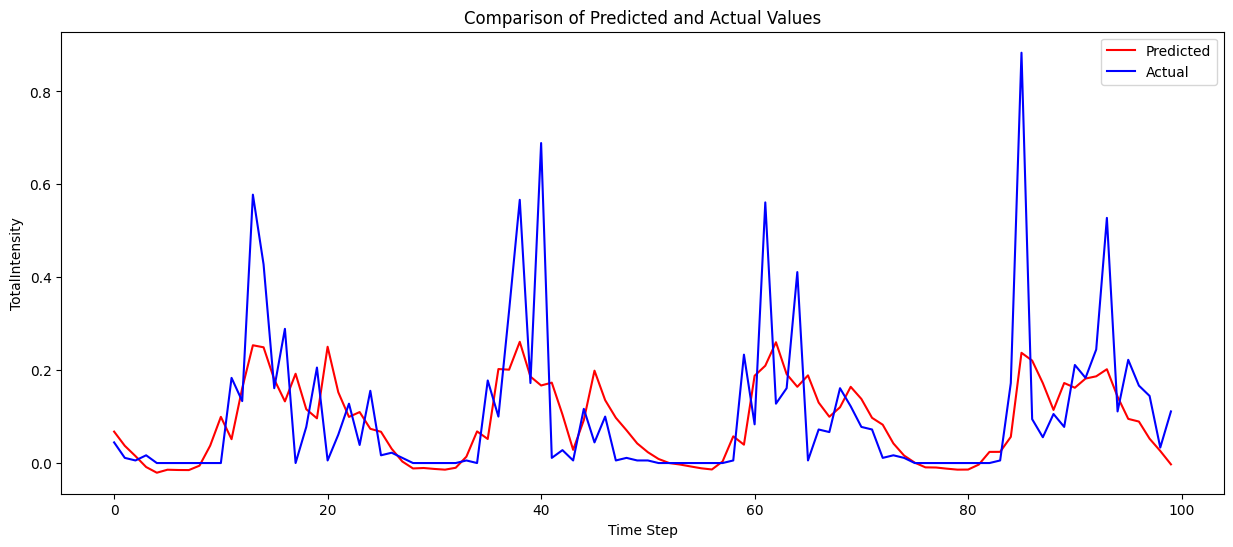

In [17]:
import matplotlib.pyplot as plt
# Convert predictions and actual values to NumPy arrays for easier handling
predictions_array = np.array(all_predictions).flatten()
actual_values_array = np.array(actual_values).flatten()

# Create a line plot to compare the first 100 predicted and actual values
plt.figure(figsize=(15, 6))
plt.plot(predictions_array[:100], label='Predicted', color='red')
plt.plot(actual_values_array[:100], label='Actual', color='blue')
plt.xlabel('Time Step')
plt.ylabel('TotalIntensity')
plt.title('Comparison of Predicted and Actual Values')
plt.legend()
plt.show()

# Interpretation of Results: SHAP Analysis

In [21]:
import shap
shap_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)
# Retrieve the first batch
for batch_X, batch_y in shap_loader:
    break
print(batch_X.shape)
explainer = shap.DeepExplainer(model, batch_X.to(device))

shap_values = explainer.shap_values(batch_X.to(device))

shap.initjs()
shap.force_plot(explainer.expected_value[0].numpy(), shap_values[0][0], batch_X[0].numpy())

torch.Size([10, 10, 4])


AssertionError: The SHAP explanations do not sum up to the model's output! This is either because of a rounding error or because an operator in your computation graph was not fully supported. If the sum difference of %f is significant compared to the scale of your model outputs, please post as a github issue, with a reproducible example so we can debug it. Used framework: pytorch - Max. diff: 0.036557830538185954 - Tolerance: 0.01